<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Coarse_Grained_Simulations_with_Martini_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Standard MD simulations, while incredibly valuable, can be computationally intensive and time-consuming, often limiting our ability to study long-timescale processes in biology.

To overcome these limitations, coarse-grained (CG) simulations have emerged as a powerful solution.

The basic principle behind CG simulations is the mapping of multiple atoms to a single representative entity, often referred to as a bead. By doing so, we have different advantages over atomistic simulations. Here I will only mention the two that are more intuitive:

**Reduced Atom Count**: In CG simulations, multiple atoms are mapped to a single representative entity, resulting in a significantly reduced number of atoms in the system. This reduction in atom count allows for more efficient computations and faster simulations.

**Larger Timesteps**: The simplification of the system in CG simulations also enables the use of larger timesteps compared to atomistic simulations. With fewer degrees of freedom to consider, CG simulations can effectively explore longer timescales, potentially up to 20 fs or even more. This larger timestep further contributes to the computational speedup of CG simulations.


The general workflow is not particularly different from a standard MD simulation. The only thing we need to change is the initial step since the protein will need to be converted from an atomistic structure to a coarse-grained one but the rest will be pretty much similar to a standard MD simulation

In [1]:
# https://www.compchems.com/gromacs-tutorial-coarse-grained-simulations-with-martini-3-force-field/#cg-simulations-workflow
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [1]:
!conda --version

conda 23.11.0


In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [5]:
!pip install -q numpy py3Dmol


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 72.6 MB/s eta 0:00:00


Define the Martini Beads and Mapping:

The Martini model simplifies groups of atoms into single beads. Here's an example of how to define and map atoms to Martini beads.

In [62]:
import numpy as np

# Define atoms of a molecule
atoms = {
    'atom1': [1.0, 2.0, 3.0],
    'atom2': [2.0, 3.0, 4.0],
    'atom3': [3.0, 4.0, 5.0],
    'atom4': [4.0, 5.0, 6.0]
}

# Define mapping of atoms to Martini beads
mapping = {
    'bead1': ['atom1', 'atom2'],
    'bead2': ['atom3', 'atom4']
}

# Calculate the position of each Martini bead as the center of mass of the mapped atoms
beads = {}
for bead, atoms_list in mapping.items():
    positions = np.array([atoms[atom] for atom in atoms_list])
    beads[bead] = np.mean(positions, axis=0)

print(beads)


{'bead1': array([1.5, 2.5, 3.5]), 'bead2': array([3.5, 4.5, 5.5])}


Visualize the Coarse-Grained Structure with Py3Dmol

In [67]:
import py3Dmol

# Create Py3Dmol viewer
view = py3Dmol.view(width=800, height=600)

# Add atoms as spheres
for atom, pos in atoms.items():
    view.addSphere({'center': {'x': pos[0], 'y': pos[1], 'z': pos[2]}, 'radius': 0.3, 'color': 'red'})

# Add beads as larger spheres
for bead, pos in beads.items():
    view.addSphere({'center': {'x': pos[0], 'y': pos[1], 'z': pos[2]}, 'radius': 0.5, 'color': 'blue'})

# Show the visualization
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Coarse-Graining with FENE Interactions

FENE (Finite Extensible Nonlinear Elastic) interactions are commonly used in coarse-grained models to represent bonded interactions with nonlinear elasticity.

<ipython-input-64-721635b7e43f>:5: RuntimeWarning: divide by zero encountered in log
  return -0.5 * k * R0**2 * np.log(1 - (r / R0)**2)


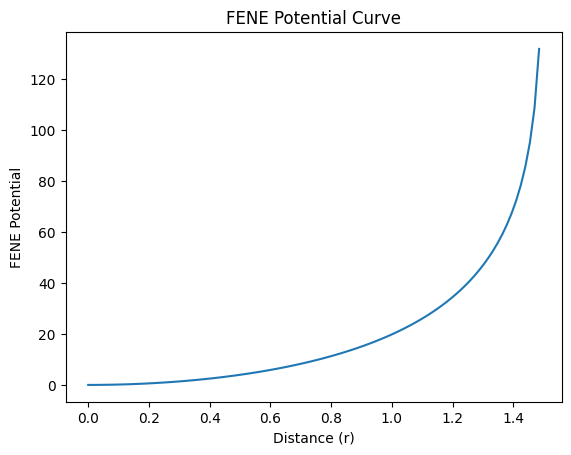

In [64]:
import matplotlib.pyplot as plt

def fene_potential(r, k=30.0, R0=1.5):
    """Calculate the FENE potential."""
    return -0.5 * k * R0**2 * np.log(1 - (r / R0)**2)

# Plot the FENE potential
r = np.linspace(0, 1.5, 100)
potential = fene_potential(r)

plt.plot(r, potential)
plt.xlabel('Distance (r)')
plt.ylabel('FENE Potential')
plt.title('FENE Potential Curve')
plt.show()


Apply FENE Interactions in a Coarse-Grained Simulation

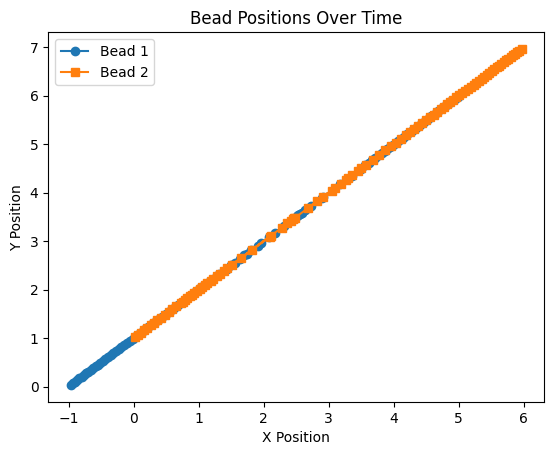

In [66]:
# Define initial positions of coarse-grained beads
beads_positions = np.array([
    [1.5, 2.5, 3.5],
    [3.5, 4.5, 5.5]
])

# Define FENE parameters
k = 30.0
R0 = 1.5

# Function to calculate FENE force
def fene_force(r, k=30.0, R0=1.5):
    """Calculate the FENE force."""
    return -k * r / (1 - (r / R0)**2)

# Simple simulation loop
timesteps = 100
positions = [beads_positions.copy()]
for _ in range(timesteps):
    r = np.linalg.norm(beads_positions[1] - beads_positions[0])
    force = fene_force(r, k, R0)
    direction = (beads_positions[1] - beads_positions[0]) / r
    beads_positions[0] += force * direction * 0.01
    beads_positions[1] -= force * direction * 0.01
    positions.append(beads_positions.copy())

# Plot the positions of the beads over time
positions = np.array(positions)
plt.plot(positions[:, 0, 0], positions[:, 0, 1], '-o',label='Bead 1')
plt.plot(positions[:, 1, 0], positions[:, 1, 1], '-s',label='Bead 2')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Bead Positions Over Time')
plt.legend()
plt.show()


More involved example

In [10]:
!conda install -c salilab dssp -y --quiet

Channels:
 - salilab
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - dssp


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.6.2   |       hbcca054_0         152 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    dssp-3.0.0                 |       h3fd9d12_4         3.1 MB  salilab
    libboost-1.84.0            |       h8013b2b_2         2.7 MB  conda-forge
    openssl-3.3.1              |       h4ab18f5_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.8 MB

The following NEW packages will be INSTALLED:

  dssp               salilab/linux-64::dssp-3.0.0-h3fd9d12_4 
  libboost           conda-forge/linux-6

In [11]:
!conda install gromacs -y --quiet

Channels:
 - conda-forge
 - salilab
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gromacs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    fftw-3.3.10                |nompi_hc118613_109         1.9 MB  conda-forge
    gromacs-2023.4             |nompi_h76c6bb2_104        27.8 MB  conda-forge
    libgfortran-ng-13.2.0      |       h69a702a_7          24 KB  conda-forge
    libgfortran5-13.2.0        |       hca663fb_7         1.4 MB  conda-forge
    libhwloc-2.10.0            |default_h5622ce7_1001         2.3 MB  conda-forge
    libxml2-2.12.7             |       hc051c1a_1         688 KB  conda-forge
    ocl-icd-2.3.2              |       hd590300_1         133 KB  conda-forge
    ------------------------------------------------------------
                                           Tot

In [12]:
pip install -q vermouth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.6 MB/s eta 0:00:00


In [13]:
pip install -q git+https://github.com/marrink-lab/vermouth-martinize.git#vermouth


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [14]:
pip install -q insane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.0 MB/s eta 0:00:00


First of all, we can download an atomistic structure from the Protein Data Bank. As an example, we are going to use the famous lysozyme (PDB ID: 1AKI)

In [15]:
!wget http://www.pdb.org/pdb/files/1AKI.pdb


--2024-06-05 23:52:46--  http://www.pdb.org/pdb/files/1AKI.pdb
Resolving www.pdb.org (www.pdb.org)... 128.6.159.96
Connecting to www.pdb.org (www.pdb.org)|128.6.159.96|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.rcsb.org/pdb/files/1AKI.pdb [following]
--2024-06-05 23:52:46--  https://www.rcsb.org/pdb/files/1AKI.pdb
Resolving www.rcsb.org (www.rcsb.org)... 128.6.159.248
Connecting to www.rcsb.org (www.rcsb.org)|128.6.159.248|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.rcsb.org/download/1AKI.pdb [following]
--2024-06-05 23:52:46--  https://files.rcsb.org/download/1AKI.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.157
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1AKI.pdb’

1AKI.pdb                [  <=>               ] 11

The first thing to do as always is to make sure to clean the protein from other molecules. You can use the grep command

In [16]:
!grep -v HETATM 1AKI.pdb > 1aki_clean.pdb


In [12]:
!ls

1aki_clean.pdb	1AKI.pdb  condacolab_install.log  sample_data


In [17]:
!which mkdssp

/usr/local/bin/mkdssp


Check martinize2 is installed

In [18]:
!martinize2 -h


usage: martinize2 [-h] [-V] [-f INPATH] [-x OUTPATH] [-o TOP_PATH] [-sep] [-merge MERGE_CHAINS]
                  [-resid RESID_HANDLING] [-ignore IGNORE_RES [IGNORE_RES ...]] [-ignh]
                  [-model MODELIDX] [-bonds-from {name,distance,none,both}]
                  [-bonds-fudge BONDS_FUDGE] [-ff TO_FF] [-from FROM_FF] [-ff-dir EXTRA_FF_DIR]
                  [-map-dir EXTRA_MAP_DIR] [-list-ff] [-list-blocks] [-p {none,all,backbone}]
                  [-pf POSRES_FC] [-dssp [DSSP] | -ss SEQUENCE | -collagen] [-ed] [-elastic]
                  [-ef RB_FORCE_CONSTANT] [-el RB_LOWER_BOUND] [-eu RB_UPPER_BOUND]
                  [-ermd RES_MIN_DIST] [-ea RB_DECAY_FACTOR] [-ep RB_DECAY_POWER]
                  [-em RB_MINIMUM_FORCE] [-eb RB_SELECTION] [-eunit RB_UNIT] [-go GO]
                  [-go-eps GO_EPS] [-go-moltype GOVS_MOLTYPE] [-go-low GO_LOW] [-go-up GO_UP]
                  [-go-res-dist GO_RES_DIST] [-water-bias]
                  [-water-bias-eps WATER_BIAS_EPS [W

In [19]:
import py3Dmol
with open("1AKI.pdb") as ifile:
    system = "".join([x for x in ifile])
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [20]:
import py3Dmol
with open("1aki_clean.pdb") as ifile:
    system = "".join([x for x in ifile])
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

To convert the clean atomistic structure of the protein to CG and generate the corresponding topology file we can use the Martinize

In [21]:
!martinize2 -f 1aki_clean.pdb -x 1aki_cg.pdb -o topol.top -ff martini3001 -scfix -cys auto -p backbone -elastic -ef 700.0 -el 0.5 -eu 0.9


    INFO - general - Read 1 molecules from PDB file 1aki_clean.pdb
    INFO - step - Guessing the bonds.
    INFO - general - 1 molecules after guessing bonds
    INFO - step - Repairing the graph.
    INFO - general - Applying modification N-ter to residue A-LYS1
    INFO - general - Applying modification C-ter to residue A-LEU129
    INFO - step - Dealing with modifications.
    INFO - general - Identified the modifications ['N-ter'] on residues ['LYS1', 'LYS1', 'LYS1', 'LYS1']
    INFO - general - Identified the modifications ['C-ter'] on residues ['LEU129', 'LEU129', 'LEU129']
    INFO - step - Read input.
    INFO - step - Creating the graph at the target resolution.
    INFO - general - Applying modification mapping ('C-ter',)
    INFO - general - Applying modification mapping ('N-ter',)
    INFO - step - Averaging the coordinates.
    INFO - step - Applying the links.
    INFO - step - Placing the charge dummies.
    INFO - step - Applying position restraints.
    INFO - step - 

In [19]:
# # !martinize2 -f 1aki_clean.pdb -dssp /usr/local/bin/mkdssp -x 1aki_cg.pdb -o topol.top -ff martini3001 -scfix -cys auto -p backbone -elastic -ef 700.0 -el 0.5 -eu 0.9
# !martinize2 -f 1aki_clean.pdb  -x 1aki_cg.pdb -o topol.top -ff martini3001 -scfix -cys auto -p backbone -elastic -ef 700.0 -el 0.5 -eu 0.9


After obtaining our coarse-grained (CG) structure, we need to prepare the system for the simulation. This process typically involves three essential steps: solvation, ion addition for system neutrality, and optionally embedding the protein in a membrane environment.

In [22]:
!insane -f 1aki_cg.pdb -o system.gro -p topol.top -d 7 -sol W:100 -salt 0.15


; NDX Solute 1 304
; Charge of protein: 8.000000
; NDX Membrane 305 0
; Charge of membrane: 0.000000
; Total charge: 8.000000
; NDX Solvent 305 11210
; NDX System 1 11210
; "I mean, the good stuff is just INSANE" --Julia Ormond


In [23]:
!wget https://www.compchems.com/martini_itp.tar.gz -O martini_itp.tar.gz

--2024-06-05 23:53:31--  https://www.compchems.com/martini_itp.tar.gz
Resolving www.compchems.com (www.compchems.com)... 172.67.160.7, 104.21.14.160, 2606:4700:3033::ac43:a007, ...
Connecting to www.compchems.com (www.compchems.com)|172.67.160.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/gzip]
Saving to: ‘martini_itp.tar.gz’

martini_itp.tar.gz      [ <=>                ]   1.28M  --.-KB/s    in 0.1s    

2024-06-05 23:53:31 (12.2 MB/s) - ‘martini_itp.tar.gz’ saved [1346076]



Untar file

In [24]:
!tar -xvf martini_itp.tar.gz


martini_itp/
martini_itp/martini_v3.0.0_solvents_v1.itp
martini_itp/martini_v3.0.0_ions_v1.itp
martini_itp/martini_v3.0.0.itp


In [25]:
!ls -altr

total 2172
drwxr-xr-x 2  502 staff    4096 Jul  2  2023 martini_itp
drwxr-xr-x 4 root root     4096 Jun  4 13:31 .config
drwxr-xr-x 1 root root     4096 Jun  4 13:37 sample_data
drwxr-xr-x 1 root root     4096 Jun  5 23:45 ..
-rw-r--r-- 1 root root    22537 Jun  5 23:47 condacolab_install.log
-rw-r--r-- 1 root root   116316 Jun  5 23:52 1AKI.pdb
-rw-r--r-- 1 root root   109917 Jun  5 23:52 1aki_clean.pdb
-rw------- 1 root root    57732 Jun  5 23:53 molecule_0.itp
-rw------- 1 root root    28493 Jun  5 23:53 1aki_cg.pdb
-rw------- 1 root root      176 Jun  5 23:53 topol.top
-rw-r--r-- 1 root root   504574 Jun  5 23:53 system.gro
-rw-r--r-- 1 root root  1346076 Jun  5 23:53 martini_itp.tar.gz
drwxr-xr-x 1 root root     4096 Jun  5 23:53 .


In [26]:
!mv molecule_0.itp martini_itp


In [27]:
!ls -altr

total 2112
drwxr-xr-x 4 root root     4096 Jun  4 13:31 .config
drwxr-xr-x 1 root root     4096 Jun  4 13:37 sample_data
drwxr-xr-x 1 root root     4096 Jun  5 23:45 ..
-rw-r--r-- 1 root root    22537 Jun  5 23:47 condacolab_install.log
-rw-r--r-- 1 root root   116316 Jun  5 23:52 1AKI.pdb
-rw-r--r-- 1 root root   109917 Jun  5 23:52 1aki_clean.pdb
-rw------- 1 root root    28493 Jun  5 23:53 1aki_cg.pdb
-rw------- 1 root root      176 Jun  5 23:53 topol.top
-rw-r--r-- 1 root root   504574 Jun  5 23:53 system.gro
-rw-r--r-- 1 root root  1346076 Jun  5 23:53 martini_itp.tar.gz
drwxr-xr-x 2  502 staff    4096 Jun  5 23:53 martini_itp
drwxr-xr-x 1 root root     4096 Jun  5 23:53 .


We need to modify the topology file (topol.top) to include all the parameters we need for our simulation. This is what the file should be like:

In [28]:
lines="""#include "martini_itp/martini_v3.0.0.itp"
#include "martini_itp/martini_v3.0.0_solvents_v1.itp"
#include "martini_itp/martini_v3.0.0_ions_v1.itp"
#include "martini_itp/molecule_0.itp"

[ system ]
; name
Insanely solvated protein.

[ molecules ]
; name  number
molecule_0       1
W            10672
NA+            113
CL-            121
"""
with open('topol.top',"w") as ifile:
    ifile.write(lines)

In [29]:
!ls -altr

total 2112
drwxr-xr-x 4 root root     4096 Jun  4 13:31 .config
drwxr-xr-x 1 root root     4096 Jun  4 13:37 sample_data
drwxr-xr-x 1 root root     4096 Jun  5 23:45 ..
-rw-r--r-- 1 root root    22537 Jun  5 23:47 condacolab_install.log
-rw-r--r-- 1 root root   116316 Jun  5 23:52 1AKI.pdb
-rw-r--r-- 1 root root   109917 Jun  5 23:52 1aki_clean.pdb
-rw------- 1 root root    28493 Jun  5 23:53 1aki_cg.pdb
-rw-r--r-- 1 root root   504574 Jun  5 23:53 system.gro
-rw-r--r-- 1 root root  1346076 Jun  5 23:53 martini_itp.tar.gz
drwxr-xr-x 2  502 staff    4096 Jun  5 23:53 martini_itp
drwxr-xr-x 1 root root     4096 Jun  5 23:53 .
-rw------- 1 root root      336 Jun  5 23:54 topol.top


In [30]:
import os
os.makedirs("minim")
os.chdir("minim")


In [31]:
!pwd

/content/minim


In [32]:
!wget https://www.compchems.com/gromacs_cg/minim.mdp -O minim.mdp

--2024-06-05 23:54:39--  https://www.compchems.com/gromacs_cg/minim.mdp
Resolving www.compchems.com (www.compchems.com)... 172.67.160.7, 104.21.14.160, 2606:4700:3033::6815:ea0, ...
Connecting to www.compchems.com (www.compchems.com)|172.67.160.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 803 [application/octet-stream]
Saving to: ‘minim.mdp’

minim.mdp           100%[===================>]     803  --.-KB/s    in 0s      

2024-06-05 23:54:39 (8.13 MB/s) - ‘minim.mdp’ saved [803/803]



In [33]:
!gmx grompp -f minim.mdp -c ../system.gro -r ../system.gro -p ../topol.top -o em.tpr


                :-) GROMACS - gmx grompp, 2023.4-conda_forge (-:

Executable:   /usr/local/bin.AVX2_256/gmx
Data prefix:  /usr/local
Working dir:  /content/minim
Command line:
  gmx grompp -f minim.mdp -c ../system.gro -r ../system.gro -p ../topol.top -o em.tpr

Replacing old mdp entry 'unconstrained_start' by 'continuation'
Setting the LD random seed to -134547466

Generated 689 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'molecule_0'

Excluding 1 bonded neighbours molecule type 'W'

Excluding 1 bonded neighbours molecule type 'NA+'

Excluding 1 bonded neighbours molecule type 'CL-'

Cleaning up constraints and constant bonded interactions with virtual sites
Analysing residue names:
There are:   129    Protein residues
There are: 10906      Other residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Number of degrees of freedom in T-Coupling group rest is 33517.00
The integ

In [34]:
!gmx mdrun -v -deffnm em


                :-) GROMACS - gmx mdrun, 2023.4-conda_forge (-:

Executable:   /usr/local/bin.AVX2_256/gmx
Data prefix:  /usr/local
Working dir:  /content/minim
Command line:
  gmx mdrun -v -deffnm em

The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file em.tpr, VERSION 2023.4-conda_forge (single precision)

Update groups can not be used for this system because an incompatible virtual site type is used

Using 1 MPI thread
Using 2 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+02
   Number of steps    =        50000
Step=    0, Dmax= 1.0e-03 nm, Epot= -1.73045e+05 Fmax= 7.14852e+04, atom= 276
Step=    1, Dmax= 1.0e-03 nm, Epot= -1.73224e+05 Fmax= 4.70392e+04, atom= 276
Step=    2, Dmax= 1.2e-03 nm, Epot= -1.73430e+05 Fmax= 3.04370e+04, 

.gro coordinates are in nm, whereas *.pdb coordinates in Å
https://colab.research.google.com/github/lorenzopallante/BiomeccanicaMultiscala/blob/main/LAB/06-Gromacs/06-Gromacs.ipynb

In [35]:
!ls -altr

total 1844
drwxr-xr-x 1 root root   4096 Jun  5 23:54 ..
-rw-r--r-- 1 root root    803 Jun  5 23:54 minim.mdp
-rw-r--r-- 1 root root  10523 Jun  5 23:54 mdout.mdp
-rw-r--r-- 1 root root 227064 Jun  5 23:54 em.tpr
-rw-r--r-- 1 root root 300628 Jun  5 23:55 em.edr
-rw-r--r-- 1 root root 134640 Jun  5 23:55 em.trr
drwxr-xr-x 2 root root   4096 Jun  5 23:55 .
-rw-r--r-- 1 root root 504574 Jun  5 23:55 em.gro
-rw-r--r-- 1 root root 684686 Jun  5 23:55 em.log


                :-) GROMACS - gmx energy, 2023.4-conda_forge (-:

Executable:   /usr/local/bin.AVX2_256/gmx
Data prefix:  /usr/local
Working dir:  /content/minim
Command line:
  gmx energy -f em.edr -o example_property.xvg

Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  G96Angle         3  Restr.-Angles    4  Proper-Dih.   
  5  Improper-Dih.    6  LJ-(SR)          7  Coulomb-(SR)     8  Position-Rest.
  9  Potential       10  Pressure        11  Constr.-rmsd    12  Vir-XX        
 13  Vir-XY          14  Vir-XZ          15  Vir-YX          16  Vir-YY        
 17  Vir-YZ          18  Vir-ZX          19  Vir-ZY          20  Vir-ZZ        
 21  Pres-XX         22  Pres-XY         23  Pres-XZ         24  Pres-YX       
 25  Pres-Y

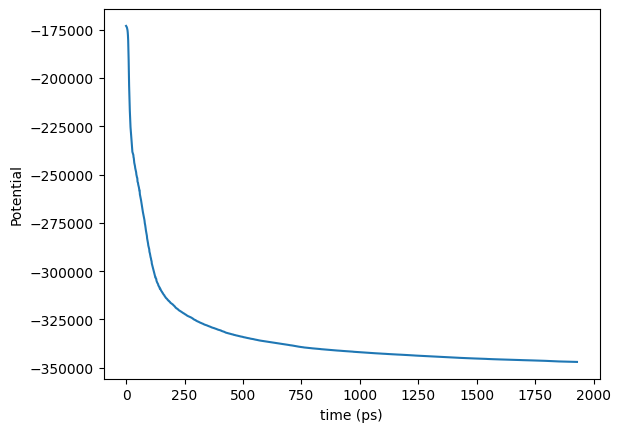

In [59]:
!echo "9 0" | gmx energy -f em.edr -o example_property.xvg
import matplotlib.pyplot as plt
import numpy as np

x,y = np.loadtxt("example_property.xvg",comments=["@", "#"],unpack=True)
plt.plot(x,y)
plt.xlabel("time (ps)")
plt.ylabel("Potential")
plt.show()

                :-) GROMACS - gmx energy, 2023.4-conda_forge (-:

Executable:   /usr/local/bin.AVX2_256/gmx
Data prefix:  /usr/local
Working dir:  /content/minim
Command line:
  gmx energy -f em.edr -o example_property.xvg

Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  G96Angle         3  Restr.-Angles    4  Proper-Dih.   
  5  Improper-Dih.    6  LJ-(SR)          7  Coulomb-(SR)     8  Position-Rest.
  9  Potential       10  Pressure        11  Constr.-rmsd    12  Vir-XX        
 13  Vir-XY          14  Vir-XZ          15  Vir-YX          16  Vir-YY        
 17  Vir-YZ          18  Vir-ZX          19  Vir-ZY          20  Vir-ZZ        
 21  Pres-XX         22  Pres-XY         23  Pres-XZ         24  Pres-YX       
 25  Pres-Y

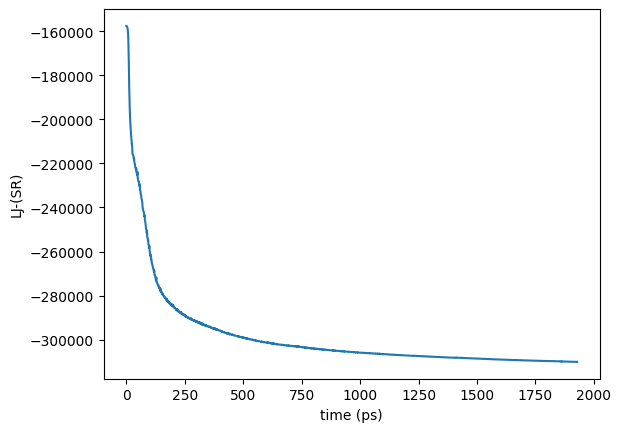

In [60]:
!echo "6 0" | gmx energy -f em.edr -o example_property.xvg
import matplotlib.pyplot as plt
import numpy as np

x,y = np.loadtxt("example_property.xvg",comments=["@", "#"],unpack=True)
plt.plot(x,y)
plt.xlabel("time (ps)")
plt.ylabel("LJ-(SR)")

plt.show()

                :-) GROMACS - gmx energy, 2023.4-conda_forge (-:

Executable:   /usr/local/bin.AVX2_256/gmx
Data prefix:  /usr/local
Working dir:  /content/minim
Command line:
  gmx energy -f em.edr -o example_property.xvg

Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  G96Angle         3  Restr.-Angles    4  Proper-Dih.   
  5  Improper-Dih.    6  LJ-(SR)          7  Coulomb-(SR)     8  Position-Rest.
  9  Potential       10  Pressure        11  Constr.-rmsd    12  Vir-XX        
 13  Vir-XY          14  Vir-XZ          15  Vir-YX          16  Vir-YY        
 17  Vir-YZ          18  Vir-ZX          19  Vir-ZY          20  Vir-ZZ        
 21  Pres-XX         22  Pres-XY         23  Pres-XZ         24  Pres-YX       
 25  Pres-Y

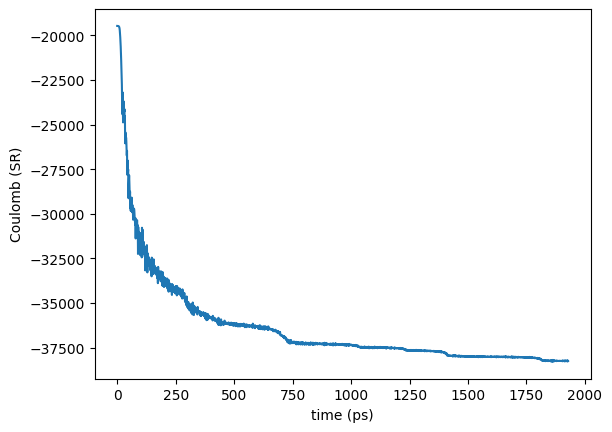

In [61]:
!echo "7 0" | gmx energy -f em.edr -o example_property.xvg
import matplotlib.pyplot as plt
import numpy as np

x,y = np.loadtxt("example_property.xvg",comments=["@", "#"],unpack=True)
plt.plot(x,y)
plt.xlabel("time (ps)")
plt.ylabel("Coulomb (SR)")
plt.savefig("volume.png", format="png", dpi=300)
plt.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [1]:
pip install numpy py3Dmol


In [2]:
import numpy as np

# Define atoms of a molecule
atoms = {
    'atom1': [1.0, 2.0, 3.0],
    'atom2': [2.0, 3.0, 4.0],
    'atom3': [3.0, 4.0, 5.0],
    'atom4': [4.0, 5.0, 6.0]
}

# Define mapping of atoms to Martini beads
mapping = {
    'bead1': ['atom1', 'atom2'],
    'bead2': ['atom3', 'atom4']
}

# Calculate the position of each Martini bead as the center of mass of the mapped atoms
beads = {}
for bead, atoms_list in mapping.items():
    positions = np.array([atoms[atom] for atom in atoms_list])
    beads[bead] = np.mean(positions, axis=0)

print(beads)


{'bead1': array([1.5, 2.5, 3.5]), 'bead2': array([3.5, 4.5, 5.5])}


In [3]:
import py3Dmol

# Create Py3Dmol viewer
view = py3Dmol.view(width=800, height=600)

# Add atoms as spheres
for atom, pos in atoms.items():
    view.addSphere({'center': {'x': pos[0], 'y': pos[1], 'z': pos[2]}, 'radius': 0.3, 'color': 'red'})

# Add beads as larger spheres
for bead, pos in beads.items():
    view.addSphere({'center': {'x': pos[0], 'y': pos[1], 'z': pos[2]}, 'radius': 0.5, 'color': 'blue'})

# Show the visualization
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<ipython-input-4-721635b7e43f>:5: RuntimeWarning: divide by zero encountered in log
  return -0.5 * k * R0**2 * np.log(1 - (r / R0)**2)


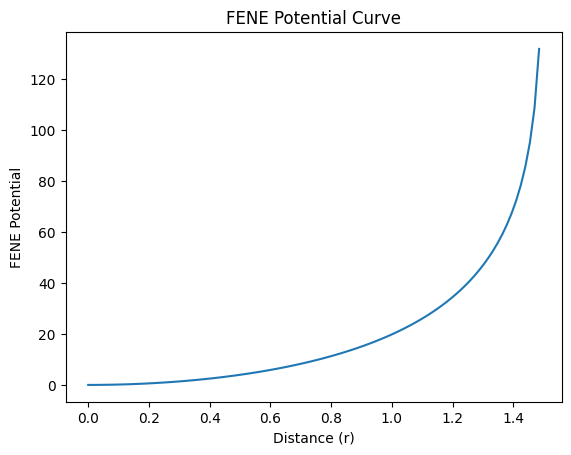

In [4]:
import matplotlib.pyplot as plt

def fene_potential(r, k=30.0, R0=1.5):
    """Calculate the FENE potential."""
    return -0.5 * k * R0**2 * np.log(1 - (r / R0)**2)

# Plot the FENE potential
r = np.linspace(0, 1.5, 100)
potential = fene_potential(r)

plt.plot(r, potential)
plt.xlabel('Distance (r)')
plt.ylabel('FENE Potential')
plt.title('FENE Potential Curve')
plt.show()


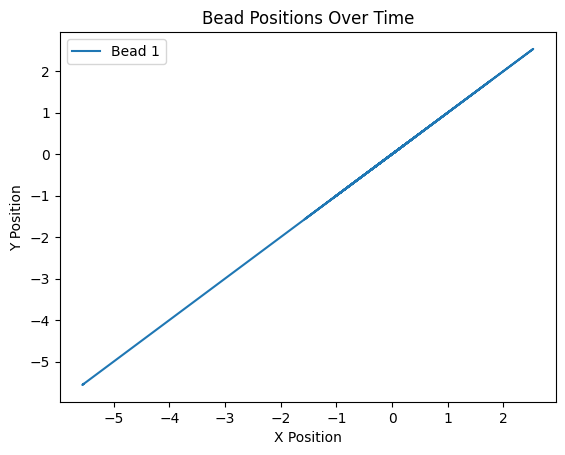

In [6]:
# Define initial positions of coarse-grained beads
beads_positions = np.array([
    [0.0, 0.0, 0.0],
    [1.0, 1.0, 1.0]
])

# Define FENE parameters
k = 30.0
R0 = 1.5

# Function to calculate FENE force
def fene_force(r, k=30.0, R0=1.5):
    """Calculate the FENE force."""
    return -k * r / (1 - (r / R0)**2)

# Simple simulation loop
timesteps = 100
positions = [beads_positions.copy()]
for _ in range(timesteps):
    r = np.linalg.norm(beads_positions[1] - beads_positions[0])
    force = fene_force(r, k, R0)
    direction = (beads_positions[1] - beads_positions[0]) / r
    beads_positions[0] += force * direction * 0.01
    beads_positions[1] -= force * direction * 0.01
    positions.append(beads_positions.copy())

# Plot the positions of the beads over time
positions = np.array(positions)
plt.plot(positions[:, 0, 0], positions[:, 0, 1], label='Bead 1')
#plt.plot(positions[:, 1, 0], positions[:, 1, 1], label='Bead 2')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Bead Positions Over Time')
plt.legend()
plt.show()
